In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns
import pycountry as pc

In [2]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(uni19_df):
    uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
    uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
    uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
    uni19_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
    uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
    # Adjacency matrix
    country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))


    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    uni19_df.rename({'Sending Organization': 'source', 'Receiving Organization':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank autority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank autority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = uni19_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = uni19_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

In [3]:
def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

In [4]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
city_df = pd.read_csv('data\worldcities.csv', sep=',', low_memory=False, header=0, encoding= 'utf8')
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
uni19_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Receiving Country Code']))))
uni19_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Sending Country Code']))))
mob_df = uni19_df.rename(columns={'Sending Organization': 'Source','Receiving Organization': 'Target', 'Participants':'weight', 'Sending Country Code': 'country'})
node_df = mob_df.iloc[:, [15,17]].drop_duplicates(subset='Source')
labels = list(range(0,4339))
node_df['source'] = labels
mob = mob_df.rename(columns={'Source': 'Target'})
node_df1 = mob.iloc[:, [15,17]].drop_duplicates(subset='Target')
node_df1["target"] = labels
results = pd.merge(mob_df,node_df, how='inner', on='Source')
results = pd.merge(results, node_df1, how='inner', on='Target')
edges_df = results.iloc[:, [27,25,23]].groupby(['source','target']).sum()
edges_df.to_csv('edges_universities1.csv')
node = pd.DataFrame()
node['Source'] = mob_df['Source'].unique()
nodes = mob_df.iloc[:, [15,16,17]].drop_duplicates(subset='Source')
#nodes = pd.merge(node,node1,how='left',on='Source').drop_duplicates(subset='Source')
city_df.rename(columns={'city_ascii':'Sending City'}, inplace=True)
city_df['Sending City'] = city_df['Sending City'].str.lower()
nodes['Sending City'] = nodes['Sending City'].str.lower()
city_df = city_df.iloc[:,[1,2,3,7]]
nodes2 = pd.merge(nodes,city_df,how='left',on='Sending City')
nodes2.drop_duplicates(subset='Source', inplace=True)
nodes2['id'] = labels
nodes2.to_csv('nodes_universities1.csv')
nodes2

,country,Sending City,Source,lat,lng,admin_name,id
0,China,beijing,China Foreign Affairs University,39.9050,116.3914,Beijing,0
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,48.2083,16.3731,Wien,1
2,Russian Federation,rostov on don,SOUTHERN FEDERAL UNIVERSITY,NaN,NaN,NaN,2
3,Russian Federation,saint petersburg,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,59.9500,30.3167,Sankt-Peterburg,3
4,Austria,wien,UNIVERSITAT WIEN,48.2083,16.3731,Wien,4
...,...,...,...,...,...,...,...
6185,UK,dunbeg oban,THE SCOTTISH ASSOCIATION FOR MARINESCIENCE LBG,NaN,NaN,NaN,4334
6186,UK,london,BIRKBECK COLLEGE - UNIVERSITY OF LONDON,51.5072,-0.1275,"London, City of",4335
6190,UK,london,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,51.5072,-0.1275,"London, City of",4336
6194,UK,london,REGENT'S UNIVERSITY LONDON LIMITED,51.5072,-0.1275,"London, City of",4337


In [5]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
uni19_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Source': nodes})
uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
# Adjacency matrix
country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

In [6]:
import networkx as nx

# G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs, create_using= nx.DiGraph)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

,country,Sending City,Source,Community,Quantity
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,0,1
7,Serbia,novi sad,UNIVERZITET U NOVOM SADU,0,1
11,Austria,wien,Fachhochschule Technikum Wien,0,1
13,Austria,wien,UNIVERSITAET FUER BODENKULTUR WIEN,0,1
16,Austria,graz,FH JOANNEUM GESELLSCHAFT MBH,0,1
...,...,...,...,...,...
4319,Slovakia,trnava,Univerzita sv. Cyrila a Metoda v Trnave,0,1
4320,Turkey,ankara,ANKARA HACI BAYRAM VELI UNIVERSITESI,0,1
4323,Turkey,serdivan,SAKARYA UYGULAMALI BILIMLER UNIVERSITESI,0,1
4324,Turkey,isparta,Isparta Uygulamali Bilimler Universitesi,0,1


,country,Sending City,Source,Community,Quantity
4,Austria,wien,UNIVERSITAT WIEN,1,1
9,Serbia,beograd,UNIVERZITET U BEOGRADU,1,1
10,Ukraine,lviv,IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,1,1
27,Austria,graz,UNIVERSITAET GRAZ,1,1
30,Bosnia and Herzegovina,sarajevo,UNIVERZITET U SARAJEVU,1,1
...,...,...,...,...,...
4298,Poland,włocławek,Panstwowa Uczelnia Zawodowa we Wloclawku,1,1
4311,Portugal,lisboa,INSTITUTO UNIVERSITARIO DE LISBOA,1,1
4321,Turkey,istanbul,BOGAZICI UNIVERSITESI,1,1
4322,Turkey,konya,KONYA TEKNIK UNIVERSITESI,1,1


,country,Sending City,Source,Community,Quantity
151,Czechia,ostrava,OSTRAVSKA UNIVERZITA,2,1
209,Germany,saarbrücken,Hochschule der Bildenden Künste Saar,2,1
210,Germany,koethen,HOCHSCHULE ANHALT,2,1
217,Germany,alfter,Alanus Hochschule gGmbH,2,1
219,Germany,berlin,Berlin International University of Applied Sci...,2,1
...,...,...,...,...,...
4275,Italy,napoli,Conservatorio San Pietro a Majella,2,1
4276,Italy,siena,"Istituto Superiore di Studi Musicali ""Rinaldo ...",2,1
4277,Italy,san domenico di fiesole fi,FONDAZIONE SCUOLA DI MUSICA DI FIESOLE ONLUS,2,1
4290,Poland,krakow,AKADEMIA MUZYCZNA IM. KRZYSZTOFA PENDERECKIEGO...,2,1


,country,Sending City,Source,Community,Quantity
53,Montenegro,podgorica,University of Donja Gorica,3,1
57,Austria,leoben,MONTANUNIVERSITAT LEOBEN,3,1
58,Ukraine,dnipropetrovsk,NATIONAL MINING UNIVERSITY,3,1
160,Belarus,mogilev,Educational Establishment Mogilev State A.Kule...,3,1
185,Serbia,niš,University of Nis,3,1
...,...,...,...,...,...
4205,France,rennes,OGEC Jean PaulII de la Salle,3,1
4239,Iceland,borgarnes,HASKOLINN A BIFROST SES,3,1
4274,Italy,benevento,Scuola Superiore per Mediatori Linguistici - I...,3,1
4279,Latvia,riga,National Defence Academy of Latvia,3,1


,country,Sending City,Source,Community,Quantity
36,Ukraine,chernivtsi,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,4,1
41,Austria,wien,PADAGOGISCHE HOCHSCHULE WIEN,4,1
123,Ukraine,kyiv,NATIONAL DRAGOMANOV PEDAGOGICAL UNIVERSITY OF ...,4,1
126,Ukraine,lviv,HIGHER EDUCATIONAL ESTABLISHMENT UKRAINIAN CAT...,4,1
135,Bulgaria,sofia,SOFIISKI UNIVERSITET SVETI KLIMENT OHRIDSKI,4,1
...,...,...,...,...,...
4136,Spain,valencia,CENTRO UNIVERSITARIO EDEM,4,1
4175,France,pau,Ecole supérieure d'art et de design des Pyrénées,4,1
4283,North Macedonia,sveti nikole,"Megjunaroden Slavjanski Univerzitet ""Gavrilo R...",4,1
4286,Norway,trondheim,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,4,1


,country,Sending City,Source,Community,Quantity
798,Albania,tirana,UNIVERSITY OF NEW YORK TIRANA,5,1
829,France,nice,Communauté d'universités et établissements Uni...,5,1
1328,Turkey,dragos kartal istanbul,ISTANBUL SEHIR UNIVERSITESI,5,1
1354,Albania,tirana,Luarasi University,5,1


,country,Sending City,Source,Community,Quantity
358,Albania,tirana,UNIVERSITETI I MJEKESISE TIRANE,6,1
447,Belarus,vitebsk,Vitebsk State Academy of Veterinary Medicine,6,1
1025,Lithuania,kaunas,LIETUVOS SVEIKATOS MOKSLU UNIVERSITETAS,6,1
1027,"Moldova, Republic of",chisinau,UNIVERSITATEA DE STAT DE MEDICINA SI FARMACIE ...,6,1
1848,Germany,hannover,STIFTUNG TIERAERZTLICHE HOCHSCHULE HANNOVER,6,1
2632,France,toulouse,ECOLE NATIONALE VETERINAIRE DE TOULOUSE,6,1
2862,Hungary,budapest,ALLATORVOSTUDOMANYI EGYETEM,6,1
3072,Ukraine,chernivtsi,Higher State Educational Establishment of Ukra...,6,1
3166,Ukraine,kharkiv,National University of Pharmacy,6,1
3624,Romania,iasi,UNIVERSITATEA DE MEDICINA SI FARMACIE GRIGORE ...,6,1


,country,Sending City,Source,Community,Quantity
215,Germany,neuendettelsau,Augustana-Hochschule,8,1
3298,Norway,oslo,DET TEOLOGISKE MENIGHETSFAKULTET,8,1
3641,Romania,cluj-napoca,Protestant Theological Institute of Cluj-Napoca,8,1
4228,Hungary,sárospatak,Sárospataki Református Teológiai Akadémia,8,1
4229,Hungary,budapest,Evangélikus Hittudományi Egyetem,8,1


,country,Sending City,Source,Community,Quantity
1051,Latvia,riga,INFORMACIJAS SISTEMU MENEDZMENTA AUGSTSKOLA SIA,19,1
1052,Ukraine,kharkiv,SIMON KUZNETS KHARKIV NATIONAL UNIVERSITY OF E...,19,1
1053,Ukraine,cherkasy,Cherkasy state business-college,19,1
4154,Spain,puerto de la cruz,Escuela Superior de Turismo iriarte,19,1


,Community,Quantity
country,,
Albania,0.0,17.0
Austria,0.0,24.0
Belarus,0.0,10.0
Belgium,0.0,31.0
Bosnia and Herzegovina,0.0,15.0
Bulgaria,0.0,23.0
Croatia,0.0,22.0
Czechia,0.0,36.0
Denmark,0.0,14.0


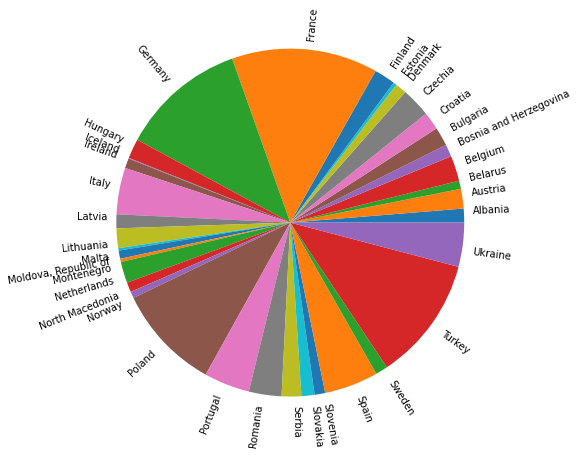

In [80]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

language_df = pd.read_csv('data\edat_aes_l26_1_Data.csv', sep=',',low_memory=False, header=0, encoding='utf8')
node_comm = nodes_df.copy()
#node_comm.drop(columns=['NodeID'], inplace=True)
node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
node_comm['Quantity']=np.ones(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
node_comm = pd.merge(nodes2,node_comm,how='inner',on='Source')
node_comm.drop(columns=['lat','lng','admin_name','id'], inplace=True)
node_comm = node_comm[node_comm['country'].str.contains('|'.join(eu_countries))==True]
for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>3):
        display(node_comm[node_comm['Community']==i])
com1_df = node_comm[node_comm['Community']==0]
label = com1_df.groupby(['country']).sum().index.get_level_values('country').tolist()
com1_df = com1_df.groupby(['country']).sum()
display(com1_df)
values = com1_df['Quantity']
#com1_df = com1_df['Quantity']/1318*100

plt.pie(values,labels= label, labeldistance=1.05,radius=2, rotatelabels=True)
plt.show()

# 52 communities. Choose if it makes sense to reduce the number of them 


percentage of foreign languages speaker in europe

In [54]:
lan_df = language_df[language_df['TIME']==2016]
l = language_df[language_df['TIME']==2007]
l = l[l['GEO']=='Turkey']
lan_df = lan_df.append(l)
lan_df = lan_df[lan_df['DEG_URB']=='Cities']
lan_df = lan_df[~lan_df['N_LANG'].str.contains('No language')]
lan_df.drop(columns=['TIME','DEG_URB','N_LANG','UNIT','Flag and Footnotes'], inplace= True)
lan_df['Value'] = pd.to_numeric(lan_df['Value'], errors='coerce')
lan_df = lan_df.groupby(['GEO']).sum()
lan_df

,Value
GEO,
Albania,55.0
Austria,93.7
Belgium,81.9
Bosnia and Herzegovina,50.9
Bulgaria,64.3
Croatia,83.2
Cyprus,93.0
Czechia,83.8
Denmark,96.7


In [8]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(uni19_df)

TypeError: 'frozenset' object is not callable